In [1]:
# Imports
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

import bambi as bmb
import catboost as cb

import matplotlib.pyplot as plt
import seaborn as sns

import arviz as az

from great_tables import *

COLOR_DICT = {
    "BLUE": "#2a5674",
    "RED": "#b13f64",
    "GOLD": "#e6b54a",
    "TEAL": "#4a9b8f",
    "CORAL": "#f47c65",
    "PURPLE": "#6a4a99",
    "ORANGE": "#f28c28",
    "GREEN": "#4a9b4a",
    "PINK": "#d47ca6"
}

COLORS = [COLOR_DICT[KEY] for KEY in COLOR_DICT.keys()]

def downcast_dtypes(df):
    float_columns = df.select_dtypes(include=["float64"]).columns
    int_columns = df.select_dtypes(include=["int64"]).columns
   
    df[float_columns] = df[float_columns].apply(pd.to_numeric, downcast="float")
    df[int_columns] = df[int_columns].apply(pd.to_numeric, downcast="integer")
   
    return df

In [2]:
## Grab the data. I have a folder of pkl files for each season of statcast data. It's just pulled directly from pybaseball.

df_list = []

for input_year in [2024,2025]:
    folder_name = './statcast_pickles//'
    pickle_name = f'statcast_{input_year}_raw.pkl'
    try:
        _df = downcast_dtypes(
            pd.read_pickle(folder_name + pickle_name)
            .dropna(subset = ['pfx_x','pfx_z','release_speed','pitch_type','release_extension','ax'])
            .query("""game_type=='R'""")
        )
        df_list.append(_df)
    except:
        print(f"Missing data for {input_year}")

df = pd.concat(df_list).reset_index(drop = True)

del df_list, _df

In [3]:
df["is_whiff"] = df["description"].isin(["swinging_strike","foul_tip","swinging_strike_blocked"]).astype(int)
df["is_bunt"] = df["description"].str.lower().str.contains("bunt").astype(int)

df['count_type'] = (
    np.where(
        (df['strikes']>=2)&(df['balls']>=3),
        'full',
        np.where(
            (df['balls']==df['strikes']),
            'even',
            np.where(
                (df['strikes']>df['balls']),
                'ahead',
                np.where(
                    (df['balls']>df['strikes']),
                    'behind',
                    np.nan
                )
            )
        )
    )
)

for flip_col in ["plate_x","pfx_x","release_pos_x"]:
    df[f"{flip_col}_bat_flip"] = np.where(df["stand"]=="R",df[flip_col].mul(-1),df[flip_col])

df["spray_angle"] = 180/np.pi*np.arctan2((df["hc_x"]-125.42),(-1*df["hc_y"]+198.27))
    

df["spray_angle_norm"] = np.where(
    df["stand"]=="R",
    df["spray_angle"].mul(-1),
    df["spray_angle"]
)

In [4]:
model_df = (
    df
    .query("""is_bunt==0""")
    .dropna(subset = [
        "bat_speed","swing_length",
        "batter","pitcher",
        "balls","strikes","count_type",
        "release_speed",
        "plate_x","plate_z",
        "stand","p_throws",
        "is_whiff","game_year",
        "pitch_type",
        "pfx_x","pfx_z",
        "description",
    ])
)

In [27]:
"""
Using bat speed and swing length vs expected was inspired by Scott Powers:
https://github.com/saberpowers/swinging-fast-and-slow
"""

'\nUsing bat speed and swing length vs expected was inspired by Scott Powers:\nhttps://github.com/saberpowers/swinging-fast-and-slow\n'

In [5]:
# bat_speed_model = bmb.Model(
#     "bat_speed ~ 1 + (0+is_whiff|batter) + (0+release_speed|batter) + (1|batter/count_type) + (0+plate_x_bat_flip|batter) + (0+plate_z|batter)",
#     data = model_df,
#     family = "gaussian"
# )

# bat_speed_idata = bat_speed_model.fit(
#     draws=500, tune=500,
#     chains=4,cores=4,
#     nuts_sampler="nutpie",
#     random_seed=3024,
#     idata_kwargs={"log_likelihood":True},
# )

In [6]:
# bat_speed_model.predict(bat_speed_idata)
# model_df["predicted_bat_speed"] = bat_speed_idata.posterior["bat_speed_mean"].mean(("chain","draw")).data

In [7]:
# swing_length_model = bmb.Model(
#     "swing_length ~ 1 + (0+is_whiff|batter) + (0+release_speed|batter) + (1|batter/count_type) + (0+plate_x_bat_flip|batter) + (0+plate_z|batter)",
#     data = model_df,
#     family = "gaussian"
# )

# swing_length_idata = swing_length_model.fit(
#     draws=500, tune=500,
#     chains=4,cores=4,
#     nuts_sampler="nutpie",
#     random_seed=3024,
#     idata_kwargs={"log_likelihood":True},
# )

In [8]:
# swing_length_model.predict(swing_length_idata)
# model_df["predicted_swing_length"] = swing_length_idata.posterior["swing_length_mean"].mean(("chain","draw")).data

In [9]:
# model_df["bat_speed_delta"]=model_df["bat_speed"]-model_df["predicted_bat_speed"]
# model_df["swing_length_delta"]=model_df["swing_length"]-model_df["predicted_swing_length"]

In [11]:
input_cols = [
    # Pitch Model cols
    "release_speed",
    "pfx_x_bat_flip",
    "pfx_z",
    "release_extension",
    "release_pos_x_bat_flip",
    "release_pos_z",
    "plate_x_bat_flip",
    "plate_z",
    # Swing cols
    "bat_speed",
    "swing_length",
    # "bat_speed_delta",
    # "swing_length_delta",
    # Categorical cols
    "stand",
    "p_throws",
    "balls",
    "strikes",
    "pitch_type",
    # Contact quality proxy
    "launch_angle",
    "spray_angle_norm",
]

cat_cols = [
    "stand",
    "p_throws",
    "balls",
    "strikes",
    "pitch_type",
]

launch_speed_model = cb.CatBoostRegressor(
    loss_function="RMSE",
    verbose=True,
    random_seed=3024,
    cat_features=cat_cols,
)

ev_df = model_df.dropna(subset=input_cols+["launch_speed"]).copy()
ev_df["balls"] = ev_df["balls"].astype(int)
ev_df["strikes"] = ev_df["strikes"].astype(int)

launch_speed_model.fit(
    ev_df[input_cols],
    ev_df["launch_speed"]
)

ev_df["launch_speed_pred"] = launch_speed_model.predict(ev_df[input_cols])
ev_df["launch_speed_delta"] = ev_df["launch_speed"]-ev_df["launch_speed_pred"]

Learning rate set to 0.087256
0:	learn: 14.0407492	total: 249ms	remaining: 4m 9s
1:	learn: 13.6504558	total: 326ms	remaining: 2m 42s
2:	learn: 13.3117858	total: 413ms	remaining: 2m 17s
3:	learn: 13.0100506	total: 511ms	remaining: 2m 7s
4:	learn: 12.7481252	total: 622ms	remaining: 2m 3s
5:	learn: 12.5162100	total: 746ms	remaining: 2m 3s
6:	learn: 12.2878165	total: 857ms	remaining: 2m 1s
7:	learn: 12.0862230	total: 946ms	remaining: 1m 57s
8:	learn: 11.9072133	total: 1.04s	remaining: 1m 54s
9:	learn: 11.7428956	total: 1.15s	remaining: 1m 53s
10:	learn: 11.6070829	total: 1.22s	remaining: 1m 49s
11:	learn: 11.4697851	total: 1.31s	remaining: 1m 47s
12:	learn: 11.3449092	total: 1.41s	remaining: 1m 46s
13:	learn: 11.2310351	total: 1.5s	remaining: 1m 45s
14:	learn: 11.1268506	total: 1.61s	remaining: 1m 45s
15:	learn: 11.0327310	total: 1.73s	remaining: 1m 46s
16:	learn: 10.9532510	total: 1.83s	remaining: 1m 46s
17:	learn: 10.8623808	total: 1.95s	remaining: 1m 46s
18:	learn: 10.7818615	total: 2.0

In [12]:
ev_df["game_date"] = pd.to_datetime(ev_df["game_date"])

comp_df = (
    ev_df
    .loc[
    (ev_df["game_date"].dt.month<4)|
    ((ev_df["game_date"].dt.month==4)&(ev_df["game_date"].dt.day<=6))
    ]
)

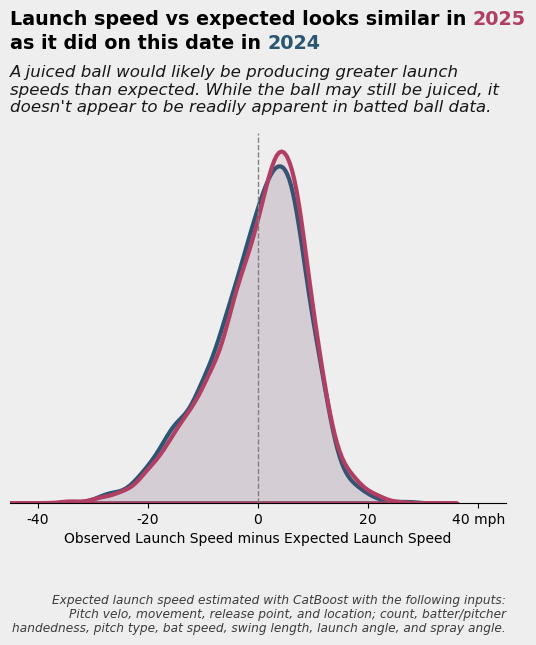

In [17]:
fig,ax=plt.subplots(facecolor="#eeeeee")

for i,season in enumerate([2024,2025]):
    sns.kdeplot(
        ax=ax,
        data=comp_df.loc[(comp_df["game_year"]==season)],
        x="launch_speed_delta",
        color=COLORS[i],
        lw=3,
        fill=True,
        alpha=0.1,
        label=season,
    )

xticks=np.linspace(-40,40,5)
xticklabels=[str(int(tick)) for tick in xticks]
xticklabels[-1]+=" mph"
ax.set(
    facecolor="#eeeeee",
    xlabel="Observed Launch Speed minus Expected Launch Speed",
    ylabel="",
    yticks=[],
    xlim=[-45,45],
    xticks=xticks,
    xticklabels=xticklabels,
)

ax.spines[["left","right","top"]].set_visible(False)
ax.axvline(0,linestyle="--",lw=1,color="gray")

full_title = """
Launch speed vs expected looks similar in 2025
as it did on this date in 2024.

A juiced ball would likely be producing greater
launch speeds than expected. While the ball may
still be juiced, it doesn't appear to be readily
apparent in batted ball data.
"""

title_text = ax.text(
    x=0,
    y=1.05,
    ha="left",
    va="bottom",
    s="""A juiced ball would likely be producing greater launch
speeds than expected. While the ball may still be juiced, it
doesn't appear to be readily apparent in batted ball data.""",
    transform=ax.transAxes,
    fontsize=12,
    style="italic",
    alpha=0.9,
)

title_text_24 = ax.annotate(
    xy=(0,1.25),
    xycoords=(title_text),
    ha="left",
    va="bottom",
    text="as it did on this date in ",
    fontsize=13.75,
    weight="bold",
)

ax.annotate(
    xy=(1,0),
    xycoords=(title_text_24),
    ha="left",
    va="bottom",
    text="2024",
    fontsize=13.75,
    weight="bold",
    color=COLORS[0]
)

title_text_25 = ax.annotate(
    xy=(0,1.25),
    xycoords=(title_text_24),
    ha="left",
    va="bottom",
    text="Launch speed vs expected looks similar in ",
    fontsize=13.75,
    weight="bold",
)

ax.annotate(
    xy=(1,0),
    xycoords=(title_text_25),
    ha="left",
    va="bottom",
    text="2025",
    fontsize=13.75,
    weight="bold",
    color=COLORS[1]
)

annotation_text = ax.text(
    x=1,
    y=-0.25,
    ha="right",
    va="top",
    s="""Expected launch speed estimated with CatBoost with the following inputs:
Pitch velo, movement, release point, and location; count, batter/pitcher
handedness, pitch type, bat speed, swing length, launch angle, and spray angle.""",
    transform=ax.transAxes,
    fontsize=8.75,
    style="italic",
    alpha=0.75,
)

plt.show()

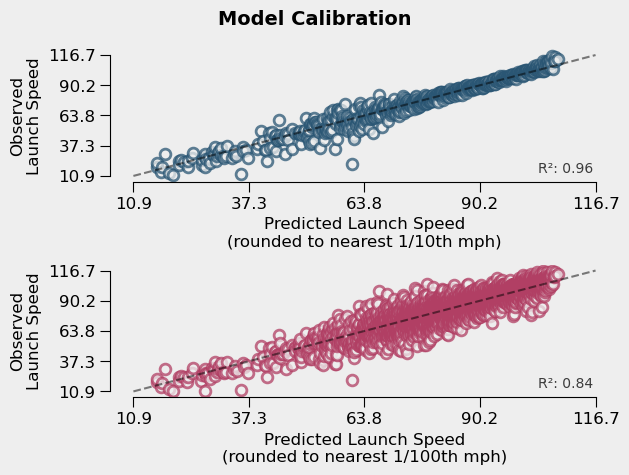

In [18]:
test_x_vars = ["launch_speed_pred","launch_speed_pred"]
test_y_vars = ["launch_speed","launch_speed"]
rounding_vars = [1,2]

y_labels=["Observed\nLaunch Speed","Observed\nLaunch Speed"]
x_labels=["Predicted Launch Speed\n(rounded to nearest 1/10th mph)","Predicted Launch Speed\n(rounded to nearest 1/100th mph)"]

fig, axes = plt.subplots(len(test_x_vars), 1, facecolor="#eeeeee")

for i, (test_x, test_y) in enumerate(zip(test_x_vars, test_y_vars)):
    ax=axes[i]
    
    plot_data = comp_df.dropna(subset=[test_x,test_y]).copy()
    plot_data[test_x] = plot_data[test_x].round(rounding_vars[i])
    scatter_data = plot_data[[test_x, test_y]].groupby([test_x]).mean().reset_index()
    
    sns.scatterplot(
        data=scatter_data, 
        x=test_x, 
        y=test_y, 
        facecolor="#eeeeee",
        edgecolor=COLORS[i],
        alpha=0.75,
        linewidth=2,
        s=60,
        ax=ax,
    )
    
    min_val = min(plot_data[test_x].min(), plot_data[test_y].min())
    max_val = max(plot_data[test_x].max(), plot_data[test_y].max())
    
    sns.lineplot(x=[min_val, max_val], y=[min_val, max_val], 
                 ax=ax, linestyle='--', color='black', alpha=0.5)
    
    corr = round((scatter_data[[test_x, test_y]].corr() ** 2).loc[test_x, test_y], 2)
    ax.annotate(
        f"R²: {corr}", 
        xy=(0.95, 0.05), 
        xycoords="axes fraction",
        ha="right", 
        va="bottom", 
        fontsize=10, 
        alpha=0.75,
    )

    mid_val = min_val + 0.5 * (max_val - min_val)
    new_range = 1.1 * (max_val - min_val)
    new_min_val = mid_val - 0.5 * new_range
    new_max_val = mid_val + 0.5 * new_range

    ax.spines[["right","top"]].set_visible(False)
    ax.spines[["left","bottom"]].set_bounds(min_val, max_val)
    ax.set_xlim(new_min_val, new_max_val)
    ax.set_ylim(new_min_val, new_max_val)
    
    ticks = np.linspace(min_val, max_val, 5)
    ax.set_xticks(ticks)
    ax.set_xticklabels(ticks.round(1), fontsize=12)
    ax.set_yticks(ticks)
    ax.set_yticklabels(ticks.round(1), fontsize=12)
    
    for axis in ["x","y"]:
        ax.tick_params(
            axis=axis, 
            color="black",
            length=7,
            direction="out",
        )
    
    ax.grid(visible=False)

    ax.set_facecolor("#eeeeee")

    ax.set_xlabel(x_labels[i], fontsize=12)
    ax.set_ylabel(y_labels[i], fontsize=12)

plt.suptitle(
    "Model Calibration",
    fontsize=14,
    weight="bold",
)

plt.tight_layout()
plt.show()

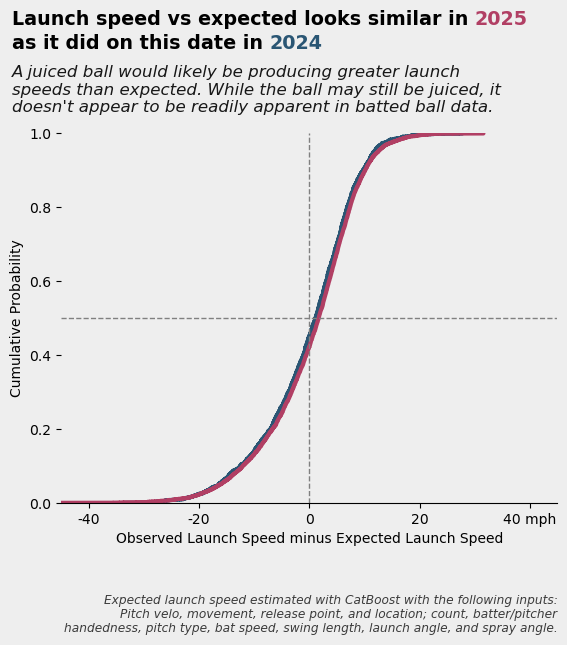

In [26]:
fig, ax = plt.subplots(facecolor="#eeeeee")

for i, season in enumerate([2024, 2025]):
    sns.ecdfplot(
        ax=ax,
        data=comp_df.loc[(comp_df["game_year"]==season)],
        x="launch_speed_delta",
        color=COLORS[i],
        lw=3,
        label=season,
    )

xticks = np.linspace(-40, 40, 5)
xticklabels = [str(int(tick)) for tick in xticks]
xticklabels[-1] += " mph"
ax.set(
    facecolor="#eeeeee",
    xlabel="Observed Launch Speed minus Expected Launch Speed",
    ylabel="Cumulative Probability",
    yticks=np.linspace(0, 1, 6),
    xlim=[-45, 45],
    xticks=xticks,
    xticklabels=xticklabels,
)

ax.spines[["left", "right", "top"]].set_visible(False)
ax.axvline(0, linestyle="--", lw=1, color="gray")
ax.axhline(0.5, linestyle="--", lw=1, color="gray")

# Title + Subtitle
full_title = """
Launch speed vs expected looks similar in 2025
as it did on this date in 2024.

A juiced ball would likely be producing greater
launch speeds than expected. While the ball may
still be juiced, it doesn't appear to be readily
apparent in batted ball data.
"""

title_text = ax.text(
    x=-0.1,
    y=1.05,
    ha="left",
    va="bottom",
    s="""A juiced ball would likely be producing greater launch
speeds than expected. While the ball may still be juiced, it
doesn't appear to be readily apparent in batted ball data.""",
    transform=ax.transAxes,
    fontsize=12,
    style="italic",
    alpha=0.9,
)

title_text_24 = ax.annotate(
    xy=(0, 1.25),
    xycoords=(title_text),
    ha="left",
    va="bottom",
    text="as it did on this date in ",
    fontsize=13.75,
    weight="bold",
)

ax.annotate(
    xy=(1, 0),
    xycoords=(title_text_24),
    ha="left",
    va="bottom",
    text="2024",
    fontsize=13.75,
    weight="bold",
    color=COLORS[0],
)

title_text_25 = ax.annotate(
    xy=(0, 1.25),
    xycoords=(title_text_24),
    ha="left",
    va="bottom",
    text="Launch speed vs expected looks similar in ",
    fontsize=13.75,
    weight="bold",
)

ax.annotate(
    xy=(1, 0),
    xycoords=(title_text_25),
    ha="left",
    va="bottom",
    text="2025",
    fontsize=13.75,
    weight="bold",
    color=COLORS[1],
)

annotation_text = ax.text(
    x=1,
    y=-0.25,
    ha="right",
    va="top",
    s="""Expected launch speed estimated with CatBoost with the following inputs:
Pitch velo, movement, release point, and location; count, batter/pitcher
handedness, pitch type, bat speed, swing length, launch angle, and spray angle.""",
    transform=ax.transAxes,
    fontsize=8.75,
    style="italic",
    alpha=0.75,
)

plt.show()
